# Face recognition project
## Nhận dạng khuôn mặt sinh viên trong lớp

## Data collection
- #Classes: 31 (collected 28)
- #Samples: 60/class

## Data exploratory analysis - Phân tích khám phá dữ liệu

In [1]:
import os

# Scan for sub-folders in the dataset path
dataset_path = 'd://datasets/faces-63cntt-clc/'

class_folder = [ f.path for f in os.scandir(dataset_path) if f.is_dir() ]

In [2]:
from os import listdir
from os.path import isfile, join

img_folders = []
print('ID\t\t#Samples')
for p in class_folder:
    img_folders.append(p.split('/')[-1])
    img_files = [f for f in listdir(p) if isfile(join(p, f))]
    print('{0}\t{1}'.format(p.split('/')[-1], len(img_files)))
    
print('Tổng số lớp = ', len(class_folder))

ID		#Samples
63130306	60
63130480	60
63130514	60
63130584	61
63130803	59
63131236	60
63131330	50
63131545	61
63132166	60
63132204	60
63132691	60
63132732	63
63132835	63
63132946	60
63132986	60
63133173	44
63133206	55
63133714	64
63133716	63
63133792	60
63134128	60
63134214	66
63134628	60
63135210	60
63135353	60
63135414	66
63135615	59
63135736	60
63135901	60
Tổng số lớp =  29


In [3]:
# Save labels to file
with open('classes.csv', 'w') as f:
    for line in img_folders:
        f.write(f"{line}\n")

## Tiềnxử lý: Phát hiện, loại bỏ ảnh có định dạng không hợp lệ

In [5]:
from pathlib import Path
import imghdr

data_dir = "D:/datasets/faces-63cntt-clc"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data preparation - Chuẩn bị dữ liệu cho mô hình nhận dạng

In [6]:
# Sử dụng thư viện Keras/TensorFlow để xây dựng mô hình CNN phân lớp ảnh
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Chọn kích thước ảnh đưa vào mô hình huấn luyện - Ảnh gốc sẽ được thay đổi (resize) 
# về kích thước này
image_size = (180, 180)
# Chọn kích thước mini-batch (số mẫu đưa vào huấn luyện tại mỗi step)
batch_size = 8

# Sử dụng thư viện Keras để chuẩn bị dataset cho quá trình học
# train_ds: train dataset - tập dùng để huấn luyện
# val_ds: validation dataset - tập dùng để kiểm tra
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,          # đường dẫn đến thư mục dataset
    validation_split=0.2,  # lấy 20% data làm tập kiểm tra
    subset="both",         # tạo ra cả 2 bộ train và val
    seed=7,             # thiết lập nhằm cho kết quả giống nhau
    image_size=image_size, 
    batch_size=batch_size,
)

Found 1548 files belonging to 27 classes.
Using 1239 files for training.
Using 309 files for validation.


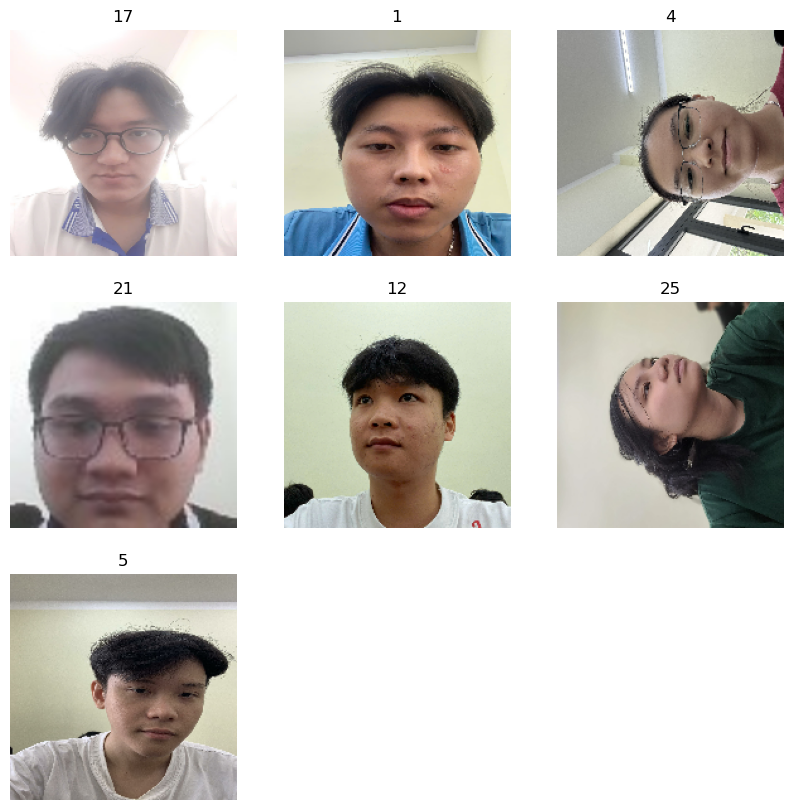

In [7]:
# View some samples - xem một số ảnh

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [8]:
# Data augmentation - Kỹ thuật tăng cường dữ liệu

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

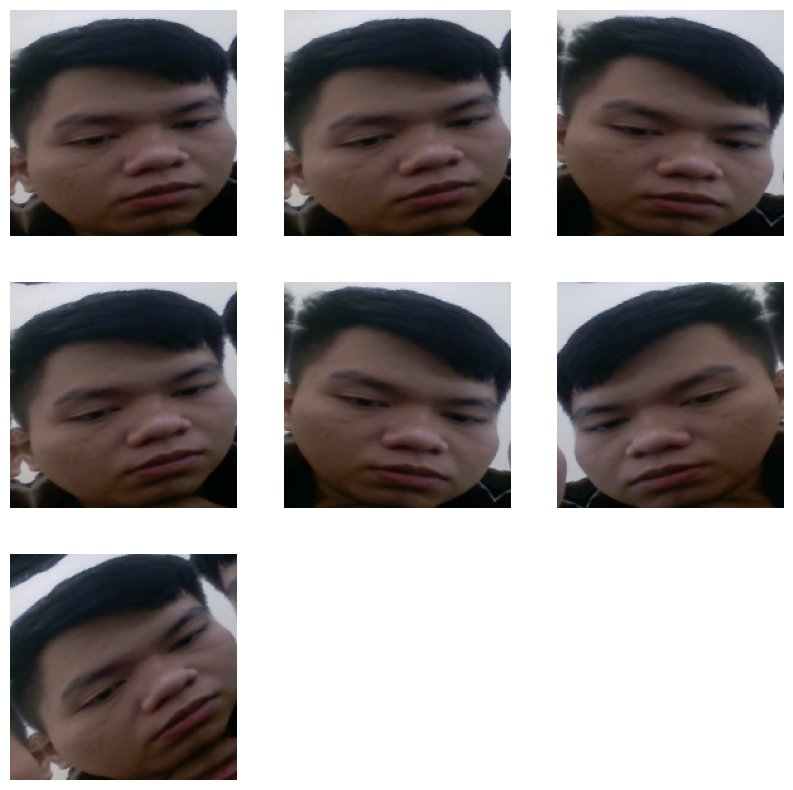

In [9]:
# View some augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(7):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
# Chuẩn hóa dữ liệu
# Đưa các giá trị điểm ảnh (0-255) về (0-1) để có kết quả tốt hơn
# cho các mô hình mạng neural

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Xây dựng mô hình nhận dạng ảnh
- Bài toán phân lớp (classification)
- Mô hình học có giám sát (supervised learning)

In [33]:
# Tạo mô hình CNN phân lớp ảnh đơn giản với Keras 
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Thêm lớp kết nối đầy đủ
model.add(layers.Flatten()) 
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(len(class_folder))) # Lớp output: số đầu ra == số SV
model.add(layers.Dense(26)) # Lớp output: số đầu ra == số SV

C:\Users\Hung\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 107584)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       6,885,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,943,450 (26.49 MB)

 Trainable params: 6,943,450 (26.49 MB)

 Non-trainable params: 0 (0.00 B)

##  Compile the model
- Chọn hàm loss: 
Đây là bài toán phân lớp, các nhãn (labels) là MSSV (categorical encoding)
- Chọn giải thuật giảm đạo hàm:
ADAM/SGD/RMSProp

In [35]:
import tensorflow as tf

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model - Huấn luyện mô hình
- Cho mô hình CNN "học" bằng cách cung cấp bộ dữ liệu huấn luyện 
có gãn nhãn (labels - học có giám sát). Mô hình sẽ thực hiện dự đoán, tính toán sai số dự đoán (hàm loss), sử dụng phương pháp 
giảm đạo hàm (gradient descent) để cập nhật bộ tham số của mô hình theo giải thuật lan truyền ngược (back propagation).

In [19]:
epochs = 10 # Số chu trình huấn luyện

# Lưu mô hình tốt nhất để sử dụng về sau
checkpoint_filepath = 'faces-best.model.keras'

# thiết lập để lưu mô hình
callbacks = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# thực hiện huấn luyện mô hình từ dữ liệu
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[callbacks],
    validation_data=val_ds)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 184ms/step - accuracy: 0.8460 - loss: 0.6031 - val_accuracy: 0.7702 - val_loss: 0.8955
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.8194 - loss: 0.5714 - val_accuracy: 0.7249 - val_loss: 1.2533
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.8313 - loss: 0.5229 - val_accuracy: 0.7864 - val_loss: 0.8383
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.8680 - loss: 0.4893 - val_accuracy: 0.7540 - val_loss: 0.9626
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 0.8477 - loss: 0.4556 - val_accuracy: 0.7540 - val_loss: 1.0786
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.8266 - loss: 0.7606 - val_accuracy: 0.1715 - val_loss: 3.0415
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - accuracy: 0.1817 - loss: 3.1468 - val_accuracy: 0.1683 - val_loss: 2.9096
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 185ms/step - accuracy: 0.1716 - loss: 2

## Save training history for later use (e.g. plot learning curve)

In [20]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# alternatively, save to json:  
# hist_json_file = 'history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)
    

## Plot learning curve - Model accuracy

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


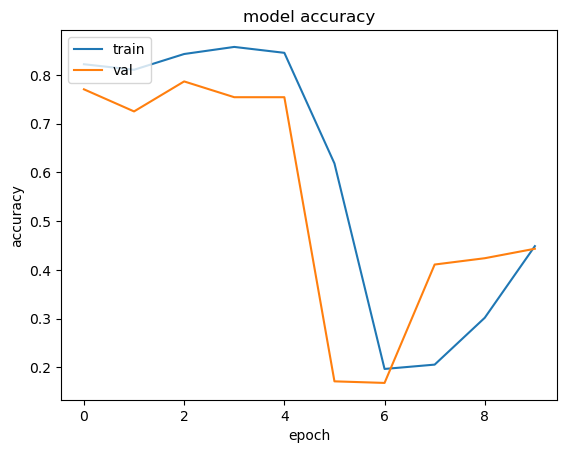

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Plot learning curve - Loss function

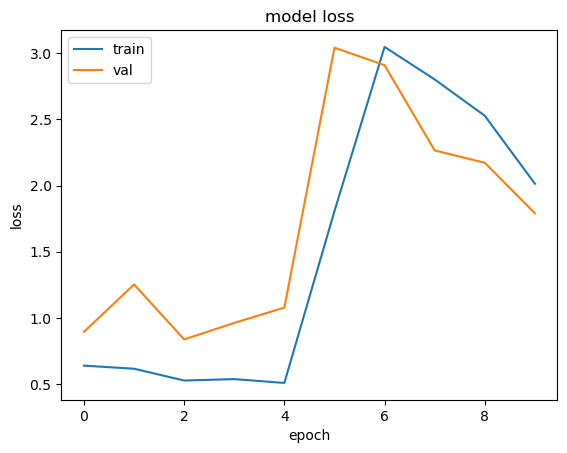

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Load the saved best model weights and make prediction

In [36]:
# Load model weights - best validation acc
model.load_weights('old-faces-best.model.keras')

C:\Users\Hung\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
# Sử dụng thư viện pandas đọc file Excel DSSV 

dssv_df = pd.read_excel('d:/datasets/DataScience-63CNTT-CLC.xlsx')

In [38]:
dssv_df.head()

,stt,mssv,ho,ten,ns,email
0,1,63133792,Dương Nhất,Duy,2003-05-30,duy.dn.63cntt@ntu.edu.vn
1,2,63133206,Ngô Thành,Đạt,2003-04-03,dat.nth.63cntt@ntu.edu.vn
2,3,63133714,Lê Nguyễn Đăng,Định,2003-02-02,dinh.lnd.63cntt@ntu.edu.vn
3,4,63133716,Trần Thái Ngọc,Đô,2003-08-18,do.ttn.63cntt@ntu.edu.vn
4,5,63130306,Nguyễn Đình,Giang,2003-06-20,giang.nd.63cntt@ntu.edu.vn


In [39]:
# Hàm lookup thông tin sinh viên dựa vào MSSV
# input: dataframe có cấu trúc như trên
def PrintStudentInfo(df):
    print('MSSV:\t', df['mssv'].values[0])
    print('Họ tên:\t', df['ho'].values[0], df['ten'].values[0])
    print('Email:\t', df['email'].values[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
MSSV:	 63130306
Họ tên:	 Nguyễn Đình Giang
Email:	 giang.nd.63cntt@ntu.edu.vn


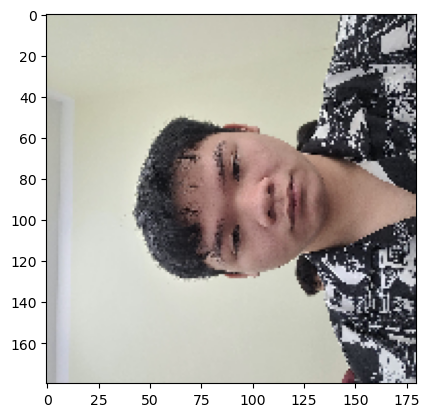

In [41]:
# Load some test samples
img = keras.utils.load_img("d:/datasets/faces-63cntt-clc/63130306/20241010_093306.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_sv = dssv_df[dssv_df['mssv'] == int(img_folders[predicted_class[0]])]
PrintStudentInfo(predicted_sv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSSV:	 63130584
Họ tên:	 Nguyễn Phước Bảo Khoa
Email:	 khoa.npb.63cntt@ntu.edu.vn


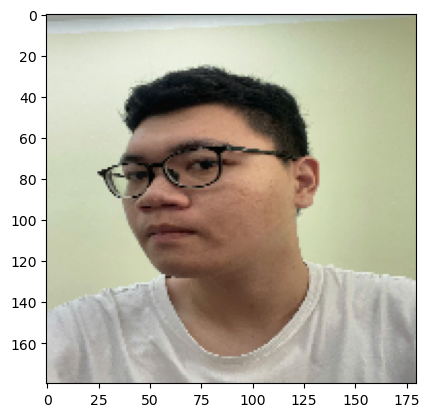

In [42]:
# Load some test samples
img = keras.utils.load_img("d:/datasets/faces-63cntt-clc/63130584/0f36d84e26559f0bc64474.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_sv = dssv_df[dssv_df['mssv'] == int(img_folders[predicted_class[0]])]
PrintStudentInfo(predicted_sv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSSV:	 63133173
Họ tên:	 Nguyễn Ngọc Gia Hưng
Email:	 hung.nng.63cntt@ntu.edu.vn


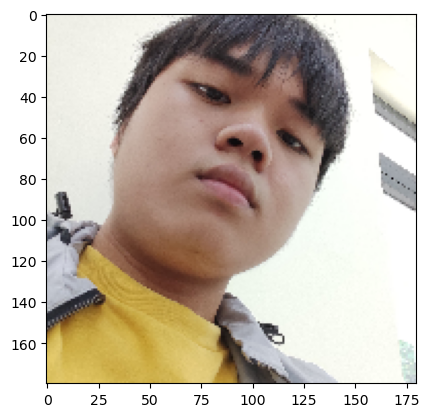

In [43]:
# Load some test samples
img = keras.utils.load_img("d:/datasets/faces-63cntt-clc/63135901/IMG_20241010_093418.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
predicted_sv = dssv_df[dssv_df['mssv'] == int(img_folders[predicted_class[0]])]
PrintStudentInfo(predicted_sv)

## Collect new test set and make evaluation on it

In [ ]:
# Evaluate the model
#loss, acc = model.evaluate(X_test, y_test, verbose=0)
#print('Test Accuracy: %.3f' % acc)